In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import statements + obtain various metrics

In [2]:
import tensorflow as tf
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K

from tensorflow.keras.utils import to_categorical  ## maintain tf.keras always

RANDOM_STATE = 2245 # for ensuring reproducible results.
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

def cosine_similarity(a, b):
### https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
    cos_sim = np.inner(a, b) / (norm(a) * norm(b))    
    return cos_sim

def get_various_metrics_and_print(Y_true, Y_predicted):
    TN, FP, FN, TP = confusion_matrix(Y_true, Y_predicted).ravel()
    accuracy = (TP + TN)/(TP+TN+FP+FN)
    recall = (TP)/(TP + FN)
    specificity = (TN)/(TN + FP) # TNR
    false_positive_rate = (FP)/(TN + FP) # false_positive_rate = 1 - TNR
    precision = (TP)/(TP + FP)
    false_discovery_rate = (FP)/(TP + FP)
    neg_predicted_val = (TN)/(TN + FN)
    f1_score = 2*((precision * recall) / (precision + recall))

    print("TN = ", TN, " FP = ", FP, " FN = ", FN, " TP = ", TP)
    print("Accuracy = ", accuracy*100, "%")
    print("TPR = Sensitivity = Recall = ", recall*100, "%")
    print("TNR = Specificity = ", specificity*100, "%")
    print("Precision = PPV = Positive Predictive Value = ", precision*100, "%")
    print("FDR = False Discovery Rate = ", false_discovery_rate*100, "%")
    print("FPR = False Positive Rate = ", false_positive_rate*100, "%")
    print("F1 Score = ", f1_score*100, "%")
    print("Neg Predicted Val = ", neg_predicted_val*100, "%")
    print("\n")
    c_report = classification_report(y_true=Y_true, y_pred=Y_predicted)
    print(c_report)
    # return precision, recall, f1_score

def plot_confusion_matrix(Y_true=None, Y_predicted=None):
    ## https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    cf_matrix = confusion_matrix(Y_true, Y_predicted)
    print(cf_matrix)
    # group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=plt.cm.magma)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load the fake-news data and display some stats.

In [3]:
!pwd

/content


In [4]:
DATE_TIME = "23-Aug-1pm"
DIMENSIONS = "32D"
# FILE_TRAIN_AND_VALIDATION = "/content/drive/My Drive/Data_Initial/contents-labels-train-val.csv"
FILE_TEST_DATA = "/content/drive/My Drive/Data_Initial/contents-labels-test.csv"
file_stop_words_bangla = "/content/drive/My Drive/Data_Initial/STOP_WORDS_BANGLA.txt"
FILE_MODEL = "/content/drive/My Drive/SAVED_MODELS/focalLoss-emb-32D-22-Aug-12pm.h5"
FILE_PATH_WEIGHTS_EMB_MODEL="/content/drive/My Drive/SAVED_MODELS/Weights/focalLoss-emb-32D-22-Aug-12pm-weights.best.hdf5"
print(f"FILE_MODEL = {FILE_MODEL}\nFILE_PATH_WEIGHTS_EMB_MODEL = {FILE_PATH_WEIGHTS_EMB_MODEL}")
file_csv = "/content/drive/My Drive/fake-news/CSV-DL_Models.csv"

FILE_MODEL = /content/drive/My Drive/SAVED_MODELS/focalLoss-emb-32D-22-Aug-12pm.h5
FILE_PATH_WEIGHTS_EMB_MODEL = /content/drive/My Drive/SAVED_MODELS/Weights/focalLoss-emb-32D-22-Aug-12pm-weights.best.hdf5


### Read (& shuffle once) the test-dataframe

In [5]:
df_test = pd.read_csv(FILE_TEST_DATA)
df_test = df_test.sample(frac=1, random_state=RANDOM_STATE)

In [6]:
print(f"len(df_test) = {len(df_test)}")

len(df_test) = 5033


In [7]:
LEN_DOC_CONTENT = 400

## All required methods

In [8]:
"""
  Loads the stop words into a list.
"""
def load_stop_words_list_and_dict(file):
  fin = open(file, 'r', encoding="utf-8") # open file
  st_words = fin.readlines() # load st-words into variable [list]
  fin.close() # close file
  stop_words_list = []
  for word in st_words: # remove new-lines/other spaces
    word = word.strip()
    stop_words_list.append(word)
  
  stop_words_dict = {} # dictionary of key-value pairs. [to do easy checking]
  for sw in stop_words_list:
          stop_words_dict[sw.strip()] = "" # for each stop word, it's replacement will be an empty-string
          
  return stop_words_list, stop_words_dict

stop_words_list, stop_words_dict = load_stop_words_list_and_dict(file_stop_words_bangla)

"""
  Given a sentence, it removes the stop-words and other things [stemming]
  Input: sentence, list of stop-words
  Output: stemmed sentence
"""
def obtain_stemmed_sentence(sentence, stop_words_dict): # Base code: Rafi
  stemmed_sentence = sentence # first copy the sentence
  stemmed_sentence = stemmed_sentence.replace("\n", "") # replace new line with empty-string
  # remove english words
  stemmed_sentence = re.sub(r'[।\\/“”0-9@&$%+_=<>~*#০১২৩৪৫৬৭৮৯…(){}\[\]\?\!\.a-zA-Z\…\|]+','',stemmed_sentence) # replace theese with empty-string [Mahim]
  sentences_split = re.split('[–—\s.,\-\‘\’\‘\'\\\":]',stemmed_sentence) # split wrt these delims
  label = ""
  for x in sentences_split:
    if x not in stop_words_dict and len(x) >= 2: # if word is not a stop-word append by adding a space
        label = label + " " + x
#   label = label.replace("  ", " ") # replace double spaces with one space
  return label

  
def read_from_file_and_load_vocab():
    vocab_list = []
    in_file = "/content/drive/My Drive/Data_Initial/Bangla-Vocab-22-Aug-withoutEnglish.txt"
    print(f"in_file = {in_file}")
    fin1 = open(in_file,'r', encoding="utf-8")
    for line in fin1.readlines():
        if len(line) > 1:
            vocab_list.append(line.strip())
    fin1.close()
    return vocab_list


## write_to_file_vocab()
vocab_list = read_from_file_and_load_vocab()
print("Size of list of vocab", len(vocab_list))

def get_vocab_dictionary(vocab_list):
    vocab_dict = {}
    cnt = 0
    for word in vocab_list:
        if word not in vocab_dict:
            vocab_dict[word] = cnt
        cnt += 1
    return vocab_dict

vocab_dict = get_vocab_dictionary(vocab_list)
print(len(vocab_dict))

def get_encoded_content(stemmed_sentence, vocab_dict):
    list_encoded_content = []
    for word in stemmed_sentence.split():
        if word in vocab_dict:
            encoded_int = vocab_dict[word] + 1 # since '0' is used for padding
            list_encoded_content.append(encoded_int)
    return list_encoded_content

df_test["stemmed_content"] = df_test.apply(lambda row : obtain_stemmed_sentence(row['content'], stop_words_dict), axis=1)
df_test["encoded_contents"] = df_test.apply(lambda row : get_encoded_content(row['stemmed_content'], vocab_dict=vocab_dict), axis=1)

print(df_test.iloc[0]["stemmed_content"])
print(df_test.iloc[0]["encoded_contents"])

# MIN_WORD_COUNT_TO_REMOVE = 3
# print(df_test[df_test['encoded_contents'].str.len() <= MIN_WORD_COUNT_TO_REMOVE]["stemmed_content"])
# idxToRemove = df_test[df_test['encoded_contents'].str.len() <= MIN_WORD_COUNT_TO_REMOVE].index
# df_test.drop(idxToRemove , inplace=True)

arr = np.array([len(x) for x in df_test["encoded_contents"].values])
arr.sort()
print(arr[0:10])

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def get_recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return recall

in_file = /content/drive/My Drive/Data_Initial/Bangla-Vocab-22-Aug-withoutEnglish.txt
Size of list of vocab 237931
237931
 নিজস্ব প্রতিবেদক তম বিসিএসের মৌখিক পরীক্ষার তারিখ ঘোষণা সরকারি কর্ম কমিশন পিএসসি ঘোষণা অনুযায়ী লিখিত পরীক্ষায় উত্তীর্ণ প্রার্থীদের মৌখিক পরীক্ষা অক্টোবর শেষ নভেম্বর মৌখিক পরীক্ষার রেজিস্ট্রেশন নম্বরভিত্তিক সময়সূচি পিএসসির ওয়েবসাইটে প্রকাশ বিজ্ঞপ্তিতে মৌখিক পরীক্ষা কার্যদিবসে সকাল টায় শেরেবাংলা নগরে আগারগাঁওয়ে পিএসসির প্রধান কার্যালয়ে মৌখিক পরীক্ষার প্রার্থীদের কমিশন ডাকযোগে সাক্ষাৎকারপত্র পাঠানো সাক্ষাৎকারপত্রটি কমিশনের ওয়েবসাইট প্রার্থীরা ডাউনলোড সংগ্রহ পারবেন প্রার্থী নির্ধারিত তারিখ সময়ে মৌখিক পরীক্ষার বোর্ডে উপস্থিত ব্যর্থ উক্ত প্রার্থীর মৌখিক পরীক্ষা গ্রহণ প্রার্থিতা বাতিল গণ্য সাক্ষাতের উল্লিখিত সনদ প্রত্যয়নপত্র ডকুমেন্টগুলোর মূল কপি মৌখিক পরীক্ষার বোর্ডে অবশ্যই প্রদর্শন শ্রেণির গেজেটেড কর্মকর্তা কর্তৃক সত্যায়িত উল্লিখিত কাগজপত্র কপি সাক্ষাৎকার বোর্ডে জমা অন্যথায় মৌখিক পরীক্ষা গ্রহণ চলতি বছরের এপ্রিল স্বাস্থ্য ক্যাডারে সহকারী সার্জন পদে সহকারী ডেন্টাল সার্জন 

### Load previously trained model and check for features

In [9]:
"""
stemmed_contents = df_test["stemmed_content"]

pkl_file = open('drive/My Drive/fake-news/stemmed_test_docs.pkl', 'wb')
pickle.dump(stemmed_contents,pkl_file)
pkl_file.close()
"""

'\nstemmed_contents = df_test["stemmed_content"]\n\npkl_file = open(\'drive/My Drive/fake-news/stemmed_test_docs.pkl\', \'wb\')\npickle.dump(stemmed_contents,pkl_file)\npkl_file.close()\n'

In [10]:
labels = df_test["label"].values
pkl_file = open('drive/My Drive/fake-news/test_labels.pkl', 'wb')
pickle.dump(labels,pkl_file)
pkl_file.close()

In [11]:
## from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical  ## maintain tf.keras always

In [12]:
## Form X
print(f"LEN_DOC_CONTENT = {LEN_DOC_CONTENT}")
encoded_contents = df_test['encoded_contents'].values
padded_docs_content = pad_sequences(encoded_contents, maxlen=LEN_DOC_CONTENT, padding='pre')

LEN_DOC_CONTENT = 400


## Load the trained model for prediction

## Change model path names

In [16]:
NAME="C-LSTM_with_synthesis-32-0.35"
## https://stackoverflow.com/questions/51700351/valueerror-unknown-metric-function-when-using-custom-metric-in-keras
dependencies = {
    'get_recall': get_recall,
    'get_f1': get_f1,
}
emb_model_content = tf.keras.models.load_model("/content/drive/My Drive/Copy of classifier_bi-LSTM_with_synthsis_similar_word.h5", custom_objects=dependencies)
# emb_model_content.load_weights(FILE_PATH_WEIGHTS_EMB_MODEL)
print(emb_model_content.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 32)           7613824   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400, 64)           49664     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400, 32)           24832     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

## [For checking] Classification using KERAS embedding-model

In [17]:
## Choose all.
encoded_contents_all = df_test["encoded_contents"]
print(encoded_contents_all.shape)
padded_docs_content_all = pad_sequences(encoded_contents_all, maxlen=LEN_DOC_CONTENT, padding='pre')
predicted_padded_docs_content_all = emb_model_content.predict(padded_docs_content_all)
predicted_padded_docs_content_all = np.reshape(predicted_padded_docs_content_all, 
                                           (predicted_padded_docs_content_all.shape[0], 1, -1))
print(predicted_padded_docs_content_all.shape)
print(predicted_padded_docs_content_all[0].shape)

(5033,)
(5033, 1, 2)
(1, 2)


## Normal loaded model i.e. **without** best weights

Y_test:  (array([0, 1]), array([ 165, 4868])) , THRESHOLD =  0.01
------------------------- CNN_with_char_based_text_gen Model THRESH 0.01 ------------------------------
TN =  115  FP =  50  FN =  14  TP =  4854
Accuracy =  98.72839260878203 %
TPR = Sensitivity = Recall =  99.71240755957272 %
TNR = Specificity =  69.6969696969697 %
Precision = PPV = Positive Predictive Value =  98.98042414355628 %
FDR = False Discovery Rate =  1.0195758564437194 %
FPR = False Positive Rate =  30.303030303030305 %
F1 Score =  99.34506753990995 %
Neg Predicted Val =  89.14728682170544 %


              precision    recall  f1-score   support

           0       0.89      0.70      0.78       165
           1       0.99      1.00      0.99      4868

    accuracy                           0.99      5033
   macro avg       0.94      0.85      0.89      5033
weighted avg       0.99      0.99      0.99      5033

[[ 115   50]
 [  14 4854]]


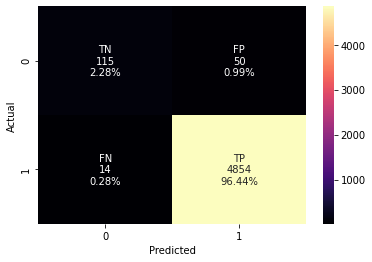

In [20]:
THRESH = 0.01
y_preds = []
for pred in predicted_padded_docs_content_all:
    # print(pred[0][0])
    if pred[0][0] >= THRESH:
        lab = 0 # [0, 1] -> 0
    else:
        lab = 1 # [1, 0] -> 1
    y_preds.append(lab)


print("Y_test: ", np.unique(df_test["label"].values, return_counts=True), ", THRESHOLD = ", THRESH)
print("------------------------- CNN_with_char_based_text_gen Model THRESH " + str(THRESH) +" ------------------------------")
get_various_metrics_and_print(Y_true=df_test["label"].values, Y_predicted=y_preds)
plot_confusion_matrix(Y_true=df_test["label"].values, Y_predicted=y_preds)

In [ ]:
 df_models = appendAndReturn_DataframeRes(df_models=df_models, clf_model_name=NAME,
                                         Y_true=df_test["label"].values, Y_predicted=y_preds)
display(df_models)
df_models.to_csv(file_csv, index=False)

NameError: ignored

In [ ]:
## Obtain the series thing.
def obtain_metrics_as_list(clf_model_name, Y_true, Y_predicted):
    # TN, FP, FN, TP = confusion_matrix(Y_true, Y_predicted).ravel()
    
    cm = confusion_matrix(Y_true, Y_predicted)
    TN, FP, FN, TP = cm.ravel()

    TNR = (TN)/(TN + FP) # TNR = Specificity
    FPR = (FP)/(TN + FP) # FPR = False Pos Rate = 1 - TNR
    recall = (TP)/(TP + FN) # TPR = Recall = Sensitivity
    FNR = (FN)/(TP + FN) # False Neg Rate = 1 - TPR
    precision = (TP)/(TP + FP) # FDR = 1 - precision
    neg_predicted_val = (TN)/(TN + FN)  # https://stats.stackexchange.com/questions/424737/is-there-a-name-for-this-metric-tn-tn-fn
    f1_score = 2*((precision * recall) / (precision + recall)) # F1-Score
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    clf_report = classification_report(y_true=Y_true, y_pred=Y_predicted)

    list_return = [] ## form list and append values
    list_return.append(clf_model_name)
    list_return.append(cm)
    list_return.append([TN, FP, FN, TP])
    list_return.append(TNR*100)
    list_return.append(FPR*100)
    list_return.append(recall*100) # recall is same as TPR
    list_return.append(FNR*100)
    list_return.append(f1_score*100)
    list_return.append(precision*100)
    list_return.append(neg_predicted_val*100)
    list_return.append(accuracy*100)
    list_return.append(clf_report)

    return list_return


############# Test the method ################
# metrics = obtain_metrics_as_list(clf_model_name="Keras-Embedding-Model", Y_true=y_test, Y_predicted=y_preds)
# print(metrics)

## Obtain and return dataframe.
def appendAndReturn_DataframeRes(df_models, clf_model_name, Y_true, Y_predicted):
    metrics = obtain_metrics_as_list(clf_model_name=clf_model_name, Y_true=Y_true, Y_predicted=Y_predicted)
    a_series = pd.Series(metrics, index=df_models.columns)
    df_models = df_models.append(a_series, ignore_index=True)
    return df_models

In [ ]:
## https://www.kite.com/python/answers/how-to-create-an-empty-dataframe-with-column-names-in-python
column_names =["Model Name", "Confusion Matrix", "[TN, FP, FN, TP]", "TNR/Specificity(%)", 
        "FPR(%)", "TPR/Recall(%)", "FNR(%)",
        "F1-Score(%)", "Precision(%)", "Negative Pred. Value (%)", "Accuracy(%)",
        "CLF-Report-SKL"]

df_models = pd.DataFrame(columns = column_names)
print(df_models.head())

Empty DataFrame
Columns: [Model Name, Confusion Matrix, [TN, FP, FN, TP], TNR/Specificity(%), FPR(%), TPR/Recall(%), FNR(%), F1-Score(%), Precision(%), Negative Pred. Value (%), Accuracy(%), CLF-Report-SKL]
Index: []


In [ ]:
display(df_models.head())

,Model Name,Confusion Matrix,"[TN, FP, FN, TP]",TNR/Specificity(%),FPR(%),TPR/Recall(%),FNR(%),F1-Score(%),Precision(%),Negative Pred. Value (%),Accuracy(%),CLF-Report-SKL


In [ ]:
## Choose all.
encoded_contents_all = df_test["encoded_contents"]
print(encoded_contents_all.shape)
padded_docs_content_all = pad_sequences(encoded_contents_all, maxlen=LEN_DOC_CONTENT, padding='pre')
predicted_padded_docs_content_all = emb_model_content.predict(padded_docs_content_all)
predicted_padded_docs_content_all = np.reshape(predicted_padded_docs_content_all, 
                                           (predicted_padded_docs_content_all.shape[0], 1, -1))
print(predicted_padded_docs_content_all.shape)
print(predicted_padded_docs_content_all[0].shape)
print(predicted_padded_docs_content_all[0:10])

(5033,)
(5033, 1, 2)
(1, 2)
[[[9.6316626e-09 1.0000000e+00]]

 [[2.0186377e-08 1.0000000e+00]]

 [[3.7342775e-07 9.9999964e-01]]

 [[1.5242482e-06 9.9999845e-01]]

 [[9.9343724e-09 1.0000000e+00]]

 [[1.9393588e-07 9.9999976e-01]]

 [[1.0297791e-08 1.0000000e+00]]

 [[5.1086417e-08 1.0000000e+00]]

 [[1.6909584e-07 9.9999988e-01]]

 [[4.1076817e-08 1.0000000e+00]]]


In [ ]:
for thresh in thresh_arr:
    name = "Focal-BiLSTM-BEST-acc-TH-" + str(round(thresh, 3))
    y_preds = get_predictions_with_thresh(preds=predicted_padded_docs_content_all, THRESH=thresh)
    print(name)
    df_models = appendAndReturn_DataframeRes(df_models=df_models, clf_model_name=name,
                                         Y_true=df_test["label"].values, Y_predicted=y_preds)


Focal-BiLSTM-BEST-acc-TH-0.05
Focal-BiLSTM-BEST-acc-TH-0.1
Focal-BiLSTM-BEST-acc-TH-0.15
Focal-BiLSTM-BEST-acc-TH-0.2
Focal-BiLSTM-BEST-acc-TH-0.25
Focal-BiLSTM-BEST-acc-TH-0.3
Focal-BiLSTM-BEST-acc-TH-0.35
Focal-BiLSTM-BEST-acc-TH-0.4
Focal-BiLSTM-BEST-acc-TH-0.45
Focal-BiLSTM-BEST-acc-TH-0.5


In [ ]:
display(df_models)

,Model Name,Confusion Matrix,"[TN, FP, FN, TP]",TNR/Specificity(%),FPR(%),TPR/Recall(%),FNR(%),F1-Score(%),Precision(%),Negative Pred. Value (%),Accuracy(%),CLF-Report-SKL
0,Focal-BiLSTM-30Ep-TH-0.05,"[[144, 21], [149, 4719]]","[144, 21, 149, 4719]",87.272727,12.727273,96.939195,3.060805,98.230641,99.556962,49.146758,96.622293,precision recall f1-score ...
1,Focal-BiLSTM-30Ep-TH-0.1,"[[144, 21], [130, 4738]]","[144, 21, 130, 4738]",87.272727,12.727273,97.329499,2.670501,98.431495,99.558731,52.554745,96.999801,precision recall f1-score ...
2,Focal-BiLSTM-30Ep-TH-0.15,"[[142, 23], [121, 4747]]","[142, 23, 121, 4747]",86.060606,13.939394,97.514380,2.485620,98.505914,99.517820,53.992395,97.138883,precision recall f1-score ...
3,Focal-BiLSTM-30Ep-TH-0.2,"[[142, 23], [110, 4758]]","[142, 23, 110, 4758]",86.060606,13.939394,97.740345,2.259655,98.621619,99.518929,56.349206,97.357441,precision recall f1-score ...
4,Focal-BiLSTM-30Ep-TH-0.25,"[[142, 23], [104, 4764]]","[142, 23, 104, 4764]",86.060606,13.939394,97.863599,2.136401,98.684619,99.519532,57.723577,97.476654,precision recall f1-score ...
5,Focal-BiLSTM-30Ep-TH-0.3,"[[142, 23], [98, 4770]]","[142, 23, 98, 4770]",86.060606,13.939394,97.986853,2.013147,98.747542,99.520134,59.166667,97.595867,precision recall f1-score ...
6,Focal-BiLSTM-30Ep-TH-0.35,"[[142, 23], [93, 4775]]","[142, 23, 93, 4775]",86.060606,13.939394,98.089565,1.910435,98.799917,99.520634,60.425532,97.695212,precision recall f1-score ...
7,Focal-BiLSTM-30Ep-TH-0.4,"[[140, 25], [89, 4779]]","[140, 25, 89, 4779]",84.848485,15.151515,98.171734,1.828266,98.821340,99.479600,61.135371,97.734949,precision recall f1-score ...
8,Focal-BiLSTM-30Ep-TH-0.45,"[[140, 25], [87, 4781]]","[140, 25, 87, 4781]",84.848485,15.151515,98.212818,1.787182,98.842258,99.479817,61.674009,97.774687,precision recall f1-score ...
9,Focal-BiLSTM-30Ep-TH-0.5,"[[140, 25], [86, 4782]]","[140, 25, 86, 4782]",84.848485,15.151515,98.233361,1.766639,98.852713,99.479925,61.946903,97.794556,precision recall f1-score ...


#### Write to csv

In [ ]:
file_csv = "/content/drive/My Drive/Notebooks-Mahim-Aug22/Focal-Loss/CSV-Focal-Loss-ThreshVary.csv"
print(f"file_csv = {file_csv}")

file_csv = /content/drive/My Drive/Notebooks-Mahim-Aug22/Focal-Loss/CSV-Focal-Loss-ThreshVary.csv


In [ ]:
df_models.to_csv(file_csv, index=False)

# Miscalenous tasks

[[ 144   21]
 [ 129 4739]]
TN =  144  FP =  21  FN =  129  TP =  4739
Accuracy =  97.0196701768329 %
TPR = Sensitivity = Recall =  97.35004108463434 %
TNR = Specificity =  87.27272727272727 %
Precision = PPV = Positive Predictive Value =  99.55882352941177 %
FDR = False Discovery Rate =  0.4411764705882353 %
FPR = False Positive Rate =  12.727272727272727 %
F1 Score =  98.44204403822185 %
Neg Predicted Val =  52.74725274725275 %


              precision    recall  f1-score   support

           0       0.53      0.87      0.66       165
           1       1.00      0.97      0.98      4868

    accuracy                           0.97      5033
   macro avg       0.76      0.92      0.82      5033
weighted avg       0.98      0.97      0.97      5033



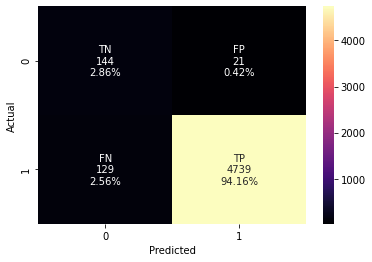

In [ ]:
## Best weights model
thresh = 0.1
y_preds = get_predictions_with_thresh(preds=predicted_padded_docs_content_all, THRESH=thresh)
plot_confusion_matrix(Y_true=df_test["label"].values, Y_predicted=y_preds)
get_various_metrics_and_print(Y_true=df_test["label"].values, Y_predicted=y_preds)

[[ 152   13]
 [ 338 4530]]
TN =  152  FP =  13  FN =  338  TP =  4530
Accuracy =  93.02602821378899 %
TPR = Sensitivity = Recall =  93.05669679539852 %
TNR = Specificity =  92.12121212121212 %
Precision = PPV = Positive Predictive Value =  99.71384547655734 %
FDR = False Discovery Rate =  0.286154523442659 %
FPR = False Positive Rate =  7.878787878787878 %
F1 Score =  96.27032196365954 %
Neg Predicted Val =  31.020408163265305 %


              precision    recall  f1-score   support

           0       0.31      0.92      0.46       165
           1       1.00      0.93      0.96      4868

    accuracy                           0.93      5033
   macro avg       0.65      0.93      0.71      5033
weighted avg       0.97      0.93      0.95      5033



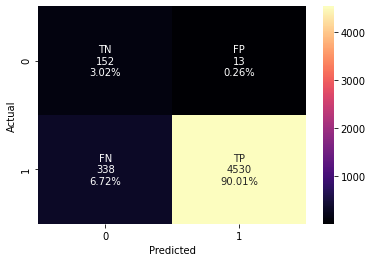

In [ ]:
## Best weights model
thresh = 0.05
y_preds = get_predictions_with_thresh(preds=predicted_padded_docs_content_all, THRESH=thresh)
plot_confusion_matrix(Y_true=df_test["label"].values, Y_predicted=y_preds)
get_various_metrics_and_print(Y_true=df_test["label"].values, Y_predicted=y_preds)

[[ 162    3]
 [2367 2501]]
TN =  162  FP =  3  FN =  2367  TP =  2501
Accuracy =  52.91078879395986 %
TPR = Sensitivity = Recall =  51.376335250616265 %
TNR = Specificity =  98.18181818181819 %
Precision = PPV = Positive Predictive Value =  99.88019169329073 %
FDR = False Discovery Rate =  0.11980830670926518 %
FPR = False Positive Rate =  1.8181818181818181 %
F1 Score =  67.85132935431362 %
Neg Predicted Val =  6.405693950177936 %


              precision    recall  f1-score   support

           0       0.06      0.98      0.12       165
           1       1.00      0.51      0.68      4868

    accuracy                           0.53      5033
   macro avg       0.53      0.75      0.40      5033
weighted avg       0.97      0.53      0.66      5033



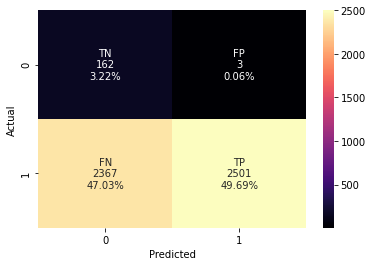

In [ ]:
## Best weights model
thresh = 0.01
y_preds = get_predictions_with_thresh(preds=predicted_padded_docs_content_all, THRESH=thresh)
plot_confusion_matrix(Y_true=df_test["label"].values, Y_predicted=y_preds)
get_various_metrics_and_print(Y_true=df_test["label"].values, Y_predicted=y_preds)

# Manual entry

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Y_test:  (array([0, 1]), array([ 165, 4868])) , THRESHOLD =  0.1
------------------------- [FOCAL LOSS] Keras Embedding Model THRESH 0.1 ------------------------------
TN =  144  FP =  21  FN =  130  TP =  4738
Accuracy =  96.99980131134512 %
TPR = Sensitivity = Recall =  97.32949876746096 %
TNR = Specificity =  87.27272727272727 %
Precision = PPV = Positive Predictive Value =  99.55873082580375 %
FDR = False Discovery Rate =  0.4412691741962597 %
FPR = False Positive Rate =  12.727272727272727 %
F1 Score =  98.43149475433675 %
Neg Predicted Val =  52.55474452554745 %


              precision    recall  f1-score   support

           0       0.53      0.87      0.66       165
           1       1.00      0.97      0.98      4868

    accuracy                           0.97      5033
   macro avg       0.76      0.92      0.82      5033
weighted avg       0.98      0.97      0.97      5033

[[ 144   21]
 [ 130 4738]]


,Model Name,Confusion Matrix,"[TN, FP, FN, TP]",TNR/Specificity(%),FPR(%),TPR/Recall(%),FNR(%),F1-Score(%),Precision(%),Negative Pred. Value (%),Accuracy(%),CLF-Report-SKL
0,Keras-Emb-THRESH-0.5-FOCAL-LOSS,"[[140, 25], [86, 4782]]","[140, 25, 86, 4782]",84.848485,15.151515,98.233361,1.766639,98.852713,99.479925,61.946903,97.794556,precision recall f1-score ...
1,Keras-Emb-THRESH-0.1-FOCAL-LOSS,"[[144, 21], [130, 4738]]","[144, 21, 130, 4738]",87.272727,12.727273,97.329499,2.670501,98.431495,99.558731,52.554745,96.999801,precision recall f1-score ...


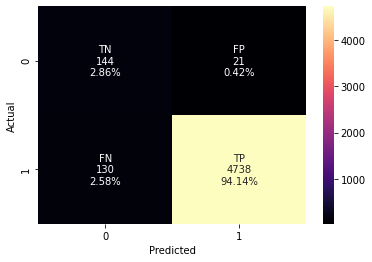

In [ ]:
THRESH = 0.1
y_preds = []
for pred in predicted_padded_docs_content_all:
    # print(pred[0][0])
    if pred[0][0] >= THRESH:
        lab = 0 # [0, 1] -> 0
    else:
        lab = 1 # [1, 0] -> 1
    y_preds.append(lab)

print(y_preds[0:20])

print("Y_test: ", np.unique(df_test["label"].values, return_counts=True), ", THRESHOLD = ", THRESH)
print("------------------------- [FOCAL LOSS] Keras Embedding Model THRESH " + str(THRESH) +" ------------------------------")
get_various_metrics_and_print(Y_true=df_test["label"].values, Y_predicted=y_preds)
plot_confusion_matrix(Y_true=df_test["label"].values, Y_predicted=y_preds)



df_models = appendAndReturn_DataframeRes(df_models=df_models, clf_model_name="Keras-Emb-THRESH-0.1-FOCAL-LOSS",
                                         Y_true=df_test["label"].values, Y_predicted=y_preds)
display(df_models)

## Receive outputs from layer 3 i.e. 32-D LSTM layer

In [ ]:
LAYER_OF_EMBEDDING_MODEL = 3
# LAYER_OF_EMBEDDING_MODEL = 2 ## JUST CHECK
emb_model_content_inside_layers = tf.keras.Model(inputs=emb_model_content.inputs , 
                                                 outputs=emb_model_content.layers[LAYER_OF_EMBEDDING_MODEL].output)
print(emb_model_content_inside_layers.summary())
# del emb_model_content

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 32)           7613824   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400, 64)           49664     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400, 32)           24832     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
Total params: 7,696,640
Trainable params: 7,696,640
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(df_test.columns.values)

['Unnamed: 0' 'articleID' 'domain' 'date' 'category' 'headline' 'content'
 'label' 'stemmed_content' 'encoded_contents']


In [ ]:
### Only choose true ones.
encoded_contents_true = df_test[df_test["label"]==1]["encoded_contents"]
print(encoded_contents_true.shape)
padded_docs_content_true = pad_sequences(encoded_contents_true, maxlen=LEN_DOC_CONTENT, padding='pre')

del encoded_contents_true

print(padded_docs_content_true[0])
print(padded_docs_content_true[0].shape)

predicted_padded_docs_content_true = emb_model_content_inside_layers.predict(padded_docs_content_true[0:10])
predicted_padded_docs_content_true = np.reshape(predicted_padded_docs_content_true, 
                                           (predicted_padded_docs_content_true.shape[0], 1, -1))

del padded_docs_content_true

print(predicted_padded_docs_content_true.shape)

for i in range(10):
    print(predicted_padded_docs_content_true[i])

(4868,)
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      

In [ ]:
### Only choose fake ones.
encoded_contents_fake = df_test[df_test["label"]==0]["encoded_contents"]
print(encoded_contents_fake.shape)
padded_docs_content_fake = pad_sequences(encoded_contents_fake, maxlen=LEN_DOC_CONTENT, padding='pre')

del encoded_contents_fake

print(padded_docs_content_fake[0])
print(padded_docs_content_fake[0].shape)

predicted_padded_docs_content_fake = emb_model_content_inside_layers.predict(padded_docs_content_fake[0:10])
predicted_padded_docs_content_fake = np.reshape(predicted_padded_docs_content_fake, 
                                           (predicted_padded_docs_content_fake.shape[0], 1, -1))

del padded_docs_content_fake

print(predicted_padded_docs_content_fake.shape)
# print(predicted_padded_docs_content[0])
for i in range(10):
    print(predicted_padded_docs_content_fake[i])

(165,)
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0

## Check cosine similarity between F-T, F-F and T-T

In [ ]:
print("--->>PRINTING of LOADED MODEL")
NUM_EXAMPLES = 5
for i in range(NUM_EXAMPLES):
    print(f"Fake {i}, True {i}: ", end='')
    print(cosine_similarity(predicted_padded_docs_content_fake[i],
                            predicted_padded_docs_content_true[i]))
    
print("\n\n")
for i in range(NUM_EXAMPLES):
    print(f"Fake {i}, Fake {i+1}: ", end='')
    print(cosine_similarity(predicted_padded_docs_content_fake[i],
                            predicted_padded_docs_content_fake[i+1]))
    
print("\n\n")
for i in range(NUM_EXAMPLES):
    print(f"True {i}, True {i+1}: ", end='')
    print(cosine_similarity(predicted_padded_docs_content_true[i],
                            predicted_padded_docs_content_true[i+1]))

--->>PRINTING of LOADED MODEL
Fake 0, True 0: [[-0.64370304]]
Fake 1, True 1: [[-0.3416622]]
Fake 2, True 2: [[-0.38167655]]
Fake 3, True 3: [[-0.45889997]]
Fake 4, True 4: [[-0.48856798]]



Fake 0, Fake 1: [[0.89406455]]
Fake 1, Fake 2: [[-0.06706163]]
Fake 2, Fake 3: [[0.12060028]]
Fake 3, Fake 4: [[0.9941515]]
Fake 4, Fake 5: [[0.15990663]]



True 0, True 1: [[0.9883277]]
True 1, True 2: [[0.9413402]]
True 2, True 3: [[0.9879075]]
True 3, True 4: [[0.9557942]]
True 4, True 5: [[0.96968734]]


## Now we obtain the predicted-output from layer-idx as mentioned above.

In [ ]:
print(padded_docs_content.shape)

# labels_as_list = df_test["labels"].values
# print(len(labels_as_list))

predicted_padded_docs_content = emb_model_content_inside_layers.predict(padded_docs_content)
predicted_padded_docs_content = np.reshape(predicted_padded_docs_content, 
                                           (predicted_padded_docs_content.shape[0], 1, -1))

print(predicted_padded_docs_content.shape)

(5033, 400)
(5033, 1, 32)


In [ ]:
print(len(df_test))
print(np.unique(df_test['label'].values, return_counts=True))

5033
(array([0, 1]), array([ 165, 4868]))


In [ ]:
## Take 10% for test; as fake samples are very low in amount.
X = predicted_padded_docs_content.reshape(predicted_padded_docs_content.shape[0], -1)

In [ ]:
Y = df_test["label"].values

## Now we load the following tree-based models.
*   **WITHOUT** hyper-parameter tuning
*   **WITH** hyper-parameter tuning

1.   DecisionTree
1.   RandomForest
1.   SVM
1.   NaiveBayes
1.   Gradient-Boosting techniques
    * XGBoost
    * Light-GBM



## Load from base-path

In [ ]:
## Load from pickel
import pickle
FOLDER_PATH_MODELS = "/content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/"
print(FOLDER_PATH_MODELS)

/content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/


#### Generic predict-classification function

In [ ]:
def load_model(name):
    filename = FOLDER_PATH_MODELS + name + '.sav'
    print("Inside load_model(), File name is {}".format(filename))
    loaded_model = pickle.load(open(filename, 'rb'))
    print("Model loading done.")
    return loaded_model

def predict_classifier(clf, X_true, Y_true, name):
    print(f"---------------- MODEL : {name} ------------------------")
    y_preds = clf.predict(X_true)
    plot_confusion_matrix(Y_true=Y_true, Y_predicted=y_preds)
    get_various_metrics_and_print(Y_true=Y_true, Y_predicted=y_preds)
    print("================================================================================")
    return y_preds

def predict_and_add_to_df_by_loading(X_true, Y_true, name, df_old):
    loaded_model = load_model(name)
    y_preds = predict_classifier(clf=loaded_model, X_true=X_true, Y_true=Y_true, name=name)
    df_new = appendAndReturn_DataframeRes(df_models=df_old, clf_model_name=name,
                Y_true=Y_true, Y_predicted=y_preds)
    return df_new

## Import statements


In [ ]:
## https://stackabuse.com/decision-trees-in-python-with-scikit-learn/
## https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
## https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
## https://scikit-learn.org/stable/modules/naive_bayes.html
## https://www.kaggle.com/ezietsman/simple-python-lightgbm-example

import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB, BernoulliNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

## Model-names [initially, but now more are added]


In [ ]:
'DTree_without_hp_tuning'
'DTree_best_hp_tuning_randomCV'
'RandomForest_without_hpTuning_100Estimators'
'RandomForest_HPTuning_RandomCV'
'SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning'
'SVM_SVC_With_HP_Tuning'
'Gaussian-NB-without-tuning'
'Bernoulli_NaiveBayes_without_hpTuning'
'XGBoost_without_hp_tuning_600_estimators_lr_0_02'
'XGBoost-best-with-hyp-tuning'

'XGBoost-best-with-hyp-tuning'

In [ ]:
model_names_arr = ['DTree_without_hp_tuning', 'DTree_best_hp_tuning_randomCV', 'RandomForest_without_hpTuning_100Estimators', 'RandomForest_HPTuning_RandomCV', 'SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning', 'SVM_SVC_With_HP_Tuning', 'Gaussian-NB-without-tuning', 'Bernoulli_NaiveBayes_without_hpTuning', 'XGBoost_without_hp_tuning_600_estimators_lr_0_02', 'XGBoost-best-with-hyp-tuning']
print(model_names_arr)

['DTree_without_hp_tuning', 'DTree_best_hp_tuning_randomCV', 'RandomForest_without_hpTuning_100Estimators', 'RandomForest_HPTuning_RandomCV', 'SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning', 'SVM_SVC_With_HP_Tuning', 'Gaussian-NB-without-tuning', 'Bernoulli_NaiveBayes_without_hpTuning', 'XGBoost_without_hp_tuning_600_estimators_lr_0_02', 'XGBoost-best-with-hyp-tuning']


In [ ]:
for model_name in model_names_arr:
    print(f"predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='{model_name}')")

predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='DTree_without_hp_tuning')
predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='DTree_best_hp_tuning_randomCV')
predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='RandomForest_without_hpTuning_100Estimators')
predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='RandomForest_HPTuning_RandomCV')
predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning')
predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='SVM_SVC_With_HP_Tuning')
predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='Gaussian-NB-without-tuning')
predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='Bernoulli_NaiveBayes_without_hpTuning')
predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='XGBoost_without_hp_tuning_600_estimators_lr_0_02')
predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='XGBoost

## Load and predict one-by-one

In [ ]:
print(X[0].shape)

(32,)


In [ ]:
print(Y[0:10])

[0 1 1 1 1 1 1 1 1 1]


In [ ]:
print(X[0])
print(X[2])

[-0.0787752  -0.04726579  0.28417376 -0.02190514 -0.43135166  0.7066639
  0.52624214 -0.22192508  0.28424916  0.22360191  0.49537387  0.11441857
 -0.0927607  -0.00752862 -0.1216308   0.3295098   0.09515199 -0.2803841
 -0.43415785 -0.01518548 -0.4927845   0.1946992  -0.22591607  0.02033884
  0.16326946  0.4867923  -0.13625365 -0.09572803  0.7392156  -0.5760939
  0.00112742  0.7390203 ]
[ 0.9477727  -0.02183838  0.97107416 -0.9832235  -0.9664228   0.64430046
  0.9037674  -0.01644396  0.00465222  0.649666    0.5937966  -0.16923341
  0.9191681   0.95955795 -0.8495707  -0.88090193  0.9146864   0.94370836
 -0.04650999 -0.9755689  -0.9778456   0.9788271  -0.8577674  -0.95758235
  0.01905507  0.961179    0.9658013  -0.9574491   0.9925848  -0.96529484
 -0.9431491   0.9465427 ]


In [ ]:
dTree = load_model("DTree_without_hp_tuning")
print(dTree)

Inside load_model(), File name is /content/drive/My Drive/Notebooks-Mahim-Aug-9/Keras-Emb-Tree-Classifiers-32D/Tree_Models_Saved/DTree_without_hp_tuning.sav
Model loading done.
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2245, splitter='best')


In [ ]:
y_preds = dTree.predict(X)
print(y_preds)

[0 1 1 ... 1 1 1]


In [ ]:
for y in y_preds:
    print(y, end='')

0111111111111111011111111111111111111111111111111111111111111111111111111111111101111111111101111111111111111111111111111111111111011111101111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111101111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111101111111110111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111011111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111011111101111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111101111111111111111111111111111111

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/DTree_without_hp_tuning.sav
Model loading done.
---------------- MODEL : DTree_without_hp_tuning ------------------------
[[ 127   38]
 [4700  168]]
TN =  127  FP =  38  FN =  4700  TP =  168
Accuracy =  5.861315318895291 %
TPR = Sensitivity = Recall =  3.451109285127362 %
TNR = Specificity =  76.96969696969697 %
Precision = PPV = Positive Predictive Value =  81.55339805825243 %
FDR = False Discovery Rate =  18.446601941747574 %
FPR = False Positive Rate =  23.03030303030303 %
F1 Score =  6.621994481671265 %
Neg Predicted Val =  2.6310337683861613 %


              precision    recall  f1-score   support

           0       0.03      0.77      0.05       165
           1       0.82      0.03      0.07      4868

    accuracy                           0.06      5033
   macro avg       0.42      0.40      0.06      5033
weighted avg       0.79     

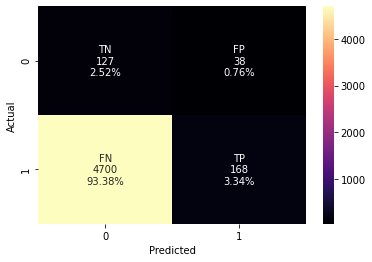

In [ ]:
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=Y, name='DTree_without_hp_tuning', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/DTree_best_hp_tuning_randomCV.sav
Model loading done.
---------------- MODEL : DTree_best_hp_tuning_randomCV ------------------------
[[   0  165]
 [ 668 4200]]
TN =  0  FP =  165  FN =  668  TP =  4200
Accuracy =  83.44923504867872 %
TPR = Sensitivity = Recall =  86.27773212818406 %
TNR = Specificity =  0.0 %
Precision = PPV = Positive Predictive Value =  96.21993127147766 %
FDR = False Discovery Rate =  3.7800687285223367 %
FPR = False Positive Rate =  100.0 %
F1 Score =  90.97801364670205 %
Neg Predicted Val =  0.0 %


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.96      0.86      0.91      4868

    accuracy                           0.83      5033
   macro avg       0.48      0.43      0.45      5033
weighted avg       0.93      0.83      0.88      5033



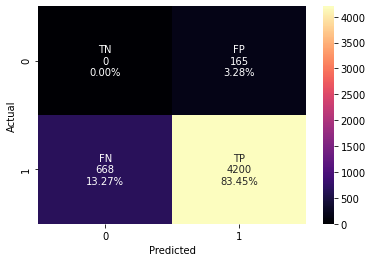

In [ ]:
# predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='DTree_best_hp_tuning_randomCV')
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='DTree_best_hp_tuning_randomCV', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/RandomForest_without_hpTuning_100Estimators.sav
Model loading done.
---------------- MODEL : RandomForest_without_hpTuning_100Estimators ------------------------
[[   9  156]
 [2243 2625]]
TN =  9  FP =  156  FN =  2243  TP =  2625
Accuracy =  52.33459169481422 %
TPR = Sensitivity = Recall =  53.92358258011504 %
TNR = Specificity =  5.454545454545454 %
Precision = PPV = Positive Predictive Value =  94.39050701186623 %
FDR = False Discovery Rate =  5.609492988133765 %
FPR = False Positive Rate =  94.54545454545455 %
F1 Score =  68.63642306183813 %
Neg Predicted Val =  0.3996447602131439 %


              precision    recall  f1-score   support

           0       0.00      0.05      0.01       165
           1       0.94      0.54      0.69      4868

    accuracy                           0.52      5033
   macro avg       0.47      0.30      0.35

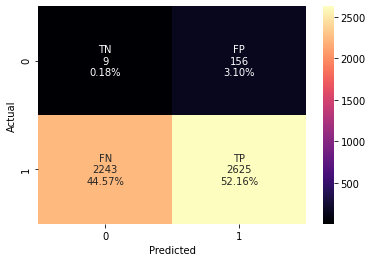

In [ ]:
# predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='RandomForest_without_hpTuning_100Estimators')
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='RandomForest_without_hpTuning_100Estimators', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/RandomForest_HPTuning_RandomCV.sav
Model loading done.
---------------- MODEL : RandomForest_HPTuning_RandomCV ------------------------
[[   0  165]
 [   0 4868]]
TN =  0  FP =  165  FN =  0  TP =  4868
Accuracy =  96.72163719451619 %
TPR = Sensitivity = Recall =  100.0 %
TNR = Specificity =  0.0 %
Precision = PPV = Positive Predictive Value =  96.72163719451619 %
FDR = False Discovery Rate =  3.2783628054838068 %
FPR = False Positive Rate =  100.0 %
F1 Score =  98.33350166649835 %
Neg Predicted Val =  nan %


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.97      1.00      0.98      4868

    accuracy                           0.97      5033
   macro avg       0.48      0.50      0.49      5033
weighted avg       0.94      0.97      0.95      5033



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


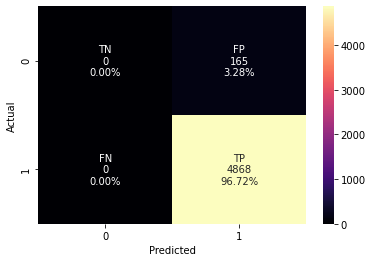

In [ ]:
# predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='RandomForest_HPTuning_RandomCV')
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='RandomForest_HPTuning_RandomCV', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning.sav
Model loading done.
---------------- MODEL : SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning ------------------------
[[   0  165]
 [ 884 3984]]
TN =  0  FP =  165  FN =  884  TP =  3984
Accuracy =  79.1575601033181 %
TPR = Sensitivity = Recall =  81.84059161873459 %
TNR = Specificity =  0.0 %
Precision = PPV = Positive Predictive Value =  96.02313810556761 %
FDR = False Discovery Rate =  3.976861894432393 %
FPR = False Positive Rate =  100.0 %
F1 Score =  88.36641898635911 %
Neg Predicted Val =  0.0 %


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.96      0.82      0.88      4868

    accuracy                           0.79      5033
   macro avg       0.48      0.41      0.44      5033
weighted avg       0.93      0.79      0.8

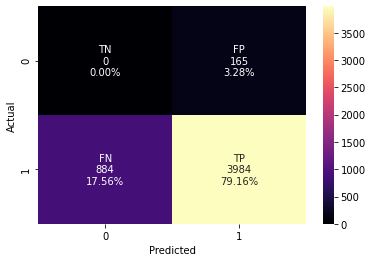

In [ ]:
# predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning')
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/SVM_SVC_With_HP_Tuning.sav
Model loading done.
---------------- MODEL : SVM_SVC_With_HP_Tuning ------------------------
[[   0  165]
 [   0 4868]]
TN =  0  FP =  165  FN =  0  TP =  4868
Accuracy =  96.72163719451619 %
TPR = Sensitivity = Recall =  100.0 %
TNR = Specificity =  0.0 %
Precision = PPV = Positive Predictive Value =  96.72163719451619 %
FDR = False Discovery Rate =  3.2783628054838068 %
FPR = False Positive Rate =  100.0 %
F1 Score =  98.33350166649835 %
Neg Predicted Val =  nan %


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.97      1.00      0.98      4868

    accuracy                           0.97      5033
   macro avg       0.48      0.50      0.49      5033
weighted avg       0.94      0.97      0.95      5033



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


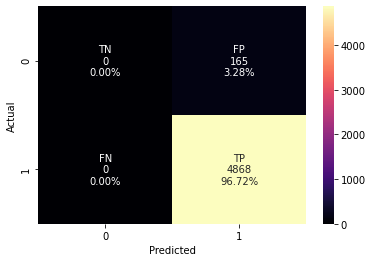

In [ ]:
# predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='SVM_SVC_With_HP_Tuning')
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='SVM_SVC_With_HP_Tuning', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/Gaussian-NB-without-tuning.sav
Model loading done.
---------------- MODEL : Gaussian-NB-without-tuning ------------------------
[[ 165    0]
 [4868    0]]
TN =  165  FP =  0  FN =  4868  TP =  0
Accuracy =  3.2783628054838068 %
TPR = Sensitivity = Recall =  0.0 %
TNR = Specificity =  100.0 %
Precision = PPV = Positive Predictive Value =  nan %
FDR = False Discovery Rate =  nan %
FPR = False Positive Rate =  0.0 %
F1 Score =  nan %
Neg Predicted Val =  3.2783628054838068 %


              precision    recall  f1-score   support

           0       0.03      1.00      0.06       165
           1       0.00      0.00      0.00      4868

    accuracy                           0.03      5033
   macro avg       0.02      0.50      0.03      5033
weighted avg       0.00      0.03      0.00      5033



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


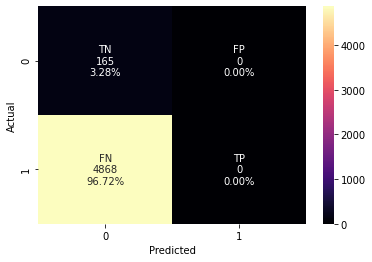

In [ ]:
# predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='Gaussian-NB-without-tuning')
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='Gaussian-NB-without-tuning', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/Gaussian_NB_hp_tuned.sav
Model loading done.
---------------- MODEL : Gaussian_NB_hp_tuned ------------------------
[[ 165    0]
 [4868    0]]
TN =  165  FP =  0  FN =  4868  TP =  0
Accuracy =  3.2783628054838068 %
TPR = Sensitivity = Recall =  0.0 %
TNR = Specificity =  100.0 %
Precision = PPV = Positive Predictive Value =  nan %
FDR = False Discovery Rate =  nan %
FPR = False Positive Rate =  0.0 %
F1 Score =  nan %
Neg Predicted Val =  3.2783628054838068 %


              precision    recall  f1-score   support

           0       0.03      1.00      0.06       165
           1       0.00      0.00      0.00      4868

    accuracy                           0.03      5033
   macro avg       0.02      0.50      0.03      5033
weighted avg       0.00      0.03      0.00      5033



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


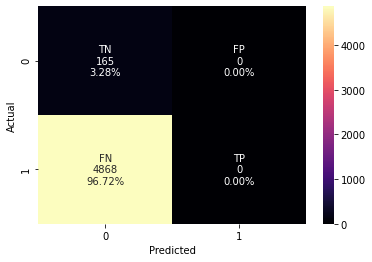

In [ ]:
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='Gaussian_NB_hp_tuned', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/Bernoulli_NaiveBayes_without_hpTuning.sav
Model loading done.
---------------- MODEL : Bernoulli_NaiveBayes_without_hpTuning ------------------------
[[ 165    0]
 [4868    0]]
TN =  165  FP =  0  FN =  4868  TP =  0
Accuracy =  3.2783628054838068 %
TPR = Sensitivity = Recall =  0.0 %
TNR = Specificity =  100.0 %
Precision = PPV = Positive Predictive Value =  nan %
FDR = False Discovery Rate =  nan %
FPR = False Positive Rate =  0.0 %
F1 Score =  nan %
Neg Predicted Val =  3.2783628054838068 %


              precision    recall  f1-score   support

           0       0.03      1.00      0.06       165
           1       0.00      0.00      0.00      4868

    accuracy                           0.03      5033
   macro avg       0.02      0.50      0.03      5033
weighted avg       0.00      0.03      0.00      5033



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


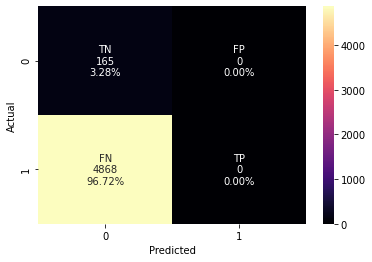

In [ ]:
# predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='Bernoulli_NaiveBayes_without_hpTuning')
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='Bernoulli_NaiveBayes_without_hpTuning', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/Bernoulli_NB_hp_tuned.sav
Model loading done.
---------------- MODEL : Bernoulli_NB_hp_tuned ------------------------
[[ 165    0]
 [4868    0]]
TN =  165  FP =  0  FN =  4868  TP =  0
Accuracy =  3.2783628054838068 %
TPR = Sensitivity = Recall =  0.0 %
TNR = Specificity =  100.0 %
Precision = PPV = Positive Predictive Value =  nan %
FDR = False Discovery Rate =  nan %
FPR = False Positive Rate =  0.0 %
F1 Score =  nan %
Neg Predicted Val =  3.2783628054838068 %


              precision    recall  f1-score   support

           0       0.03      1.00      0.06       165
           1       0.00      0.00      0.00      4868

    accuracy                           0.03      5033
   macro avg       0.02      0.50      0.03      5033
weighted avg       0.00      0.03      0.00      5033



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


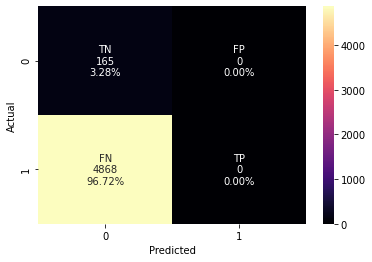

In [ ]:
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='Bernoulli_NB_hp_tuned', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/XGBoost_without_hp_tuning_600_estimators_lr_0_02.sav
Model loading done.
---------------- MODEL : XGBoost_without_hp_tuning_600_estimators_lr_0_02 ------------------------
[[  28  137]
 [ 204 4664]]
TN =  28  FP =  137  FN =  204  TP =  4664
Accuracy =  93.2247168686668 %
TPR = Sensitivity = Recall =  95.80936729663107 %
TNR = Specificity =  16.969696969696972 %
Precision = PPV = Positive Predictive Value =  97.14642782753593 %
FDR = False Discovery Rate =  2.85357217246407 %
FPR = False Positive Rate =  83.03030303030303 %
F1 Score =  96.47326507394767 %
Neg Predicted Val =  12.068965517241379 %


              precision    recall  f1-score   support

           0       0.12      0.17      0.14       165
           1       0.97      0.96      0.96      4868

    accuracy                           0.93      5033
   macro avg       0.55      0.56 

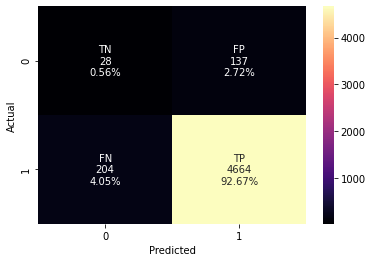

In [ ]:
# predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='XGBoost_without_hp_tuning_600_estimators_lr_0_02')
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='XGBoost_without_hp_tuning_600_estimators_lr_0_02', df_old=df_models)

Inside load_model(), File name is /content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/XGBoost-best-with-hyp-tuning.sav
Model loading done.
---------------- MODEL : XGBoost-best-with-hyp-tuning ------------------------
[[  96   69]
 [ 142 4726]]
TN =  96  FP =  69  FN =  142  TP =  4726
Accuracy =  95.80766938207829 %
TPR = Sensitivity = Recall =  97.08299096138045 %
TNR = Specificity =  58.18181818181818 %
Precision = PPV = Positive Predictive Value =  98.56100104275288 %
FDR = False Discovery Rate =  1.4389989572471324 %
FPR = False Positive Rate =  41.81818181818181 %
F1 Score =  97.81641312221878 %
Neg Predicted Val =  40.33613445378151 %


              precision    recall  f1-score   support

           0       0.40      0.58      0.48       165
           1       0.99      0.97      0.98      4868

    accuracy                           0.96      5033
   macro avg       0.69      0.78      0.73      5033
weighted avg       0

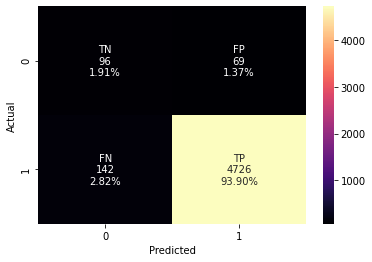

In [ ]:
# predict_by_loading(X_true=X, Y_true=df_test['label'].values, name='XGBoost-best-with-hyp-tuning')
df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='XGBoost-best-with-hyp-tuning', df_old=df_models)

## Finally LightGBM checking.

In [ ]:
print(FOLDER_PATH_MODELS)
file_load = FOLDER_PATH_MODELS + "LightGBM-without-tune.txt"
print(file_load)

/content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/
/content/drive/My Drive/Mahim-Rafi-NLP-FakeNews-Notebooks/Tree-Models-With-FocalLoss-Embeddings/TREE_MODELS/LightGBM-without-tune.txt


In [ ]:
## https://github.com/microsoft/LightGBM/issues/1217
bst = lgb.Booster(model_file=file_load)

In [ ]:
y_preds = bst.predict(X)
y_preds_conv = []

THRESHOLD = 0.5

for p in y_preds:
    if p >= THRESHOLD:
        y_preds_conv.append(1)
    else:
        y_preds_conv.append(0)


------------------ Model: LightGBM -------------------------
[[ 113   52]
 [ 130 4738]]
TN =  113  FP =  52  FN =  130  TP =  4738
Accuracy =  96.38386648122392 %
TPR = Sensitivity = Recall =  97.32949876746096 %
TNR = Specificity =  68.48484848484848 %
Precision = PPV = Positive Predictive Value =  98.91440501043841 %
FDR = False Discovery Rate =  1.0855949895615866 %
FPR = False Positive Rate =  31.515151515151512 %
F1 Score =  98.11555187409401 %
Neg Predicted Val =  46.50205761316872 %


              precision    recall  f1-score   support

           0       0.47      0.68      0.55       165
           1       0.99      0.97      0.98      4868

    accuracy                           0.96      5033
   macro avg       0.73      0.83      0.77      5033
weighted avg       0.97      0.96      0.97      5033



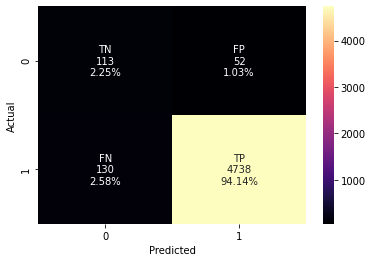

In [ ]:
Y_test = df_test['label'].values

print("------------------ Model: LightGBM -------------------------")
plot_confusion_matrix(Y_predicted=y_preds_conv, Y_true=Y_test)
get_various_metrics_and_print(Y_true=Y_test, Y_predicted=y_preds_conv)

In [ ]:
# df_models = predict_and_add_to_df_by_loading(X_true=X, Y_true=df_test['label'].values, name='LightGBM_without_tuning', df_old=df_models)
df_models = appendAndReturn_DataframeRes(df_models=df_models, clf_model_name="LightGBM_without_tuning", 
                    Y_true=df_test["label"].values, Y_predicted=y_preds_conv)

In [ ]:
display(df_models)

,Model Name,Confusion Matrix,"[TN, FP, FN, TP]",TNR/Specificity(%),FPR(%),TPR/Recall(%),FNR(%),F1-Score(%),Precision(%),Negative Pred. Value (%),Accuracy(%),CLF-Report-SKL
0,Keras-Emb-THRESH-0.5-FOCAL-LOSS,"[[140, 25], [86, 4782]]","[140, 25, 86, 4782]",84.848485,15.151515,98.233361,1.766639,98.852713,99.479925,61.946903,97.794556,precision recall f1-score ...
1,Keras-Emb-THRESH-0.1-FOCAL-LOSS,"[[144, 21], [130, 4738]]","[144, 21, 130, 4738]",87.272727,12.727273,97.329499,2.670501,98.431495,99.558731,52.554745,96.999801,precision recall f1-score ...
2,DTree_without_hp_tuning,"[[127, 38], [4700, 168]]","[127, 38, 4700, 168]",76.969697,23.030303,3.451109,96.548891,6.621994,81.553398,2.631034,5.861315,precision recall f1-score ...
3,DTree_best_hp_tuning_randomCV,"[[0, 165], [668, 4200]]","[0, 165, 668, 4200]",0.000000,100.000000,86.277732,13.722268,90.978014,96.219931,0.000000,83.449235,precision recall f1-score ...
4,RandomForest_without_hpTuning_100Estimators,"[[9, 156], [2243, 2625]]","[9, 156, 2243, 2625]",5.454545,94.545455,53.923583,46.076417,68.636423,94.390507,0.399645,52.334592,precision recall f1-score ...
5,RandomForest_HPTuning_RandomCV,"[[0, 165], [0, 4868]]","[0, 165, 0, 4868]",0.000000,100.000000,100.000000,0.000000,98.333502,96.721637,NaN,96.721637,precision recall f1-score ...
6,SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning,"[[0, 165], [884, 3984]]","[0, 165, 884, 3984]",0.000000,100.000000,81.840592,18.159408,88.366419,96.023138,0.000000,79.157560,precision recall f1-score ...
7,SVM_C_100_kernel_RBF_WITHOUT_HP_Tuning,"[[0, 165], [884, 3984]]","[0, 165, 884, 3984]",0.000000,100.000000,81.840592,18.159408,88.366419,96.023138,0.000000,79.157560,precision recall f1-score ...
8,SVM_SVC_With_HP_Tuning,"[[0, 165], [0, 4868]]","[0, 165, 0, 4868]",0.000000,100.000000,100.000000,0.000000,98.333502,96.721637,NaN,96.721637,precision recall f1-score ...
9,Gaussian-NB-without-tuning,"[[165, 0], [4868, 0]]","[165, 0, 4868, 0]",100.000000,0.000000,0.000000,100.000000,NaN,NaN,3.278363,3.278363,precision recall f1-score ...


In [ ]:
# csv_file_model = "/content/drive/My Drive/Notebooks-Mahim-Aug-9/Keras-Emb-Tree-Classifiers-32D/CSV-Models-Tree-Emb32-Keras-22Aug.csv"

In [ ]:
# df_models.to_csv(csv_file_model, index=False)